1

Parameters of the largest circle
Center: (0.0, 1103.0)
Radius: 40.069384267237695


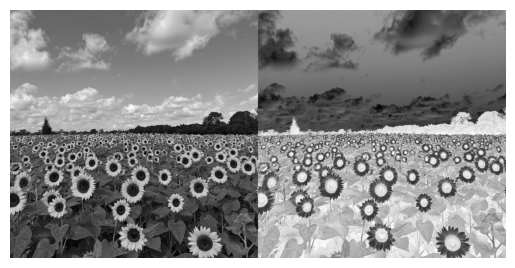

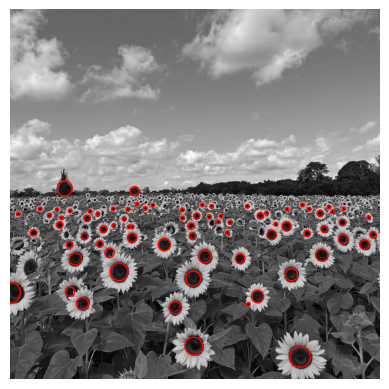

In [35]:
from math import sqrt
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.io import imread, imshow
from skimage.color import rgb2gray
import cv2 as cv
import numpy as np

import matplotlib.pyplot as plt


transform = np.arange(255,-1, -1).astype('uint8')
img_orig = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_GRAYSCALE)
img_tr= cv.LUT(img_orig, transform)

res = np.hstack((img_orig,img_tr)) #stacking images side-by-side
plt.axis('off')
plt.imshow(img_orig, cmap='gray')
plt.imshow(res , cmap='gray')
plt.savefig('ans/q1_img1.png')

blobs = blob_log(img_tr, max_sigma=40, min_sigma=5, num_sigma=10, threshold=0.3, overlap = 0.1)
fig, ax = plt.subplots()
ax.axis('off')
ax.imshow(img_orig, cmap='gray')
max_r =0;
for blob in blobs:
    y, x, area = blob
    if area>=max_r:
        max_r=area
        max_x=x
        max_y=y
    ax.add_patch(plt.Circle((x, y), area*np.sqrt(2), color='r', fill=False))
plt.savefig('ans/q1_img2.png')
print('Parameters of the largest circle')
print("Center: ({}, {})".format(max_x, max_y))
print("Radius: {}".format(max_r*np.sqrt(2)))

2

(0.7244939056621988, 0.6892812057921882, 1.3546709012879086)
RANSAC Line: 0.724x + 0.689y = 1.355


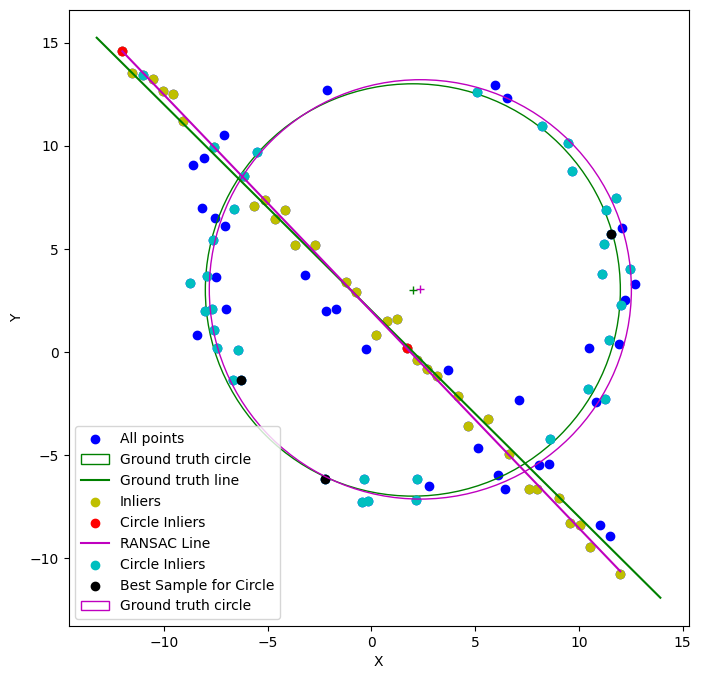

RANSAC Circle: (x - 1.181)^2 + (y - 1.514)^2 = 6.228


In [114]:
from scipy . optimize import minimize
from scipy import linalg
import matplotlib . pyplot as plt
import math
import numpy as np
#import tikzplotlib
#np . random . seed ( 0 )
N = 100
half_n = N// 2
r = 10
x0_gt , y0_gt = 2 , 3 # Center
s = r /16
t = np . random . uniform (0 , 2*np . pi , half_n )
n = s*np . random . randn ( half_n )
x1 , y1 = x0_gt + ( r + n)*np . cos ( t ) , y0_gt + ( r + n)*np . sin ( t )
X_circ = np . hstack ( ( x1. reshape ( half_n , 1 ) , y1 . reshape ( half_n , 1 ) ) )
s = 1.
m, b = -1, 2
x = np . linspace (-12, 12 , half_n )
y = m*x + b + s*np . random . randn ( half_n )
X_line = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
X = np . vstack ( ( X_circ , X_line ) ) # A l l p o in t s
fig , ax = plt . subplots (1 ,1 , figsize =(8 ,8))
ax . scatter ( X_line [ : , 0 ] , X_line [ : , 1 ] ,color='b')
ax . scatter ( X_circ [ : , 0 ] , X_circ [ : , 1 ],color='b' , label= 'All points')
circle_gt = plt . Circle ( ( x0_gt , y0_gt ) , r , color= 'g', fill =False , label= 'Ground truth circle')
ax . add_patch ( circle_gt )
ax . plot ( ( x0_gt ) , ( y0_gt ) , '+' , color= 'g')
x_min , x_max = ax . get_xlim ( )
x_ = np . array ( [ x_min , x_max ] )
y_ = m*x_ + b
plt . plot ( x_ , y_ , color= 'g', label= 'Ground truth line')
plt . legend ( )

############# LINE #############

inliercount=35
all_x =np.concatenate((x1,x))
all_y =np.concatenate((y1,y))


def fit_line(x, y):
    A = np.vstack((x, np.ones(len(x)))).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    # Normalize the coefficients a and b
    a = -m / np.sqrt(1 + m**2)
    b = 1 / np.sqrt(1 + m**2)
    c= c / np.sqrt(1 + m**2)
    return a, b, c

def calculate_distance(a, b, c, x, y):
    return np.abs(a * x + b * y - c) / np.sqrt(a**2 + b**2)

def ransac_fit_line(x, y, num_iterations, inlier_threshold):
    best_model = None
    best_inliers = []
    best_error = np.inf

    for _ in range(num_iterations):
        sample_indices = np.random.choice(len(x), 2, replace=False)
        sample_x = x[sample_indices]
        sample_y = y[sample_indices]

        a, b, c = fit_line(sample_x, sample_y)

        distances = calculate_distance(a, b, c, x, y)
        inliers = np.where(distances < inlier_threshold)[0]

        error = np.sum(distances[inliers])

        if len(inliers) >= inliercount:
            if error < best_error:
                best_model = (a, b, c)
                best_inliers = inliers
                best_error = error
                best_sample_indices=sample_indices

    return best_model, best_inliers,best_sample_indices


# Set RANSAC parameters
num_iterations = 150
inlier_threshold = 0.7

# Run RANSAC to find the best-fit line
best_fit, inliers, line_sample_indices = ransac_fit_line(all_x, all_y, num_iterations, inlier_threshold)
print(best_fit)
# Extract the best-fit line parameters
best_a, best_b, best_c = best_fit

lineSampleX=all_x[np.isin(np.arange(len(all_x)), line_sample_indices )]
lineSampleY=all_y[np.isin(np.arange(len(all_x)), line_sample_indices )]

line_inliersX = all_x[np.isin(np.arange(len(all_x)), inliers)]
line_inliersY = all_y[np.isin(np.arange(len(all_y)), inliers)]
plt.scatter(line_inliersX, line_inliersY, color='y', label='Inliers')
plt.scatter(lineSampleX,lineSampleY,color='r', label='Circle Inliers')
plt.plot(x, (best_c - best_a * x) / best_b, color='m', label='RANSAC Line')


print("RANSAC Line: %.3fx + %.3fy = %.3f" % (best_a, best_b, best_c))


############# CIRCLE #############
def fit_circle(x,y):
    x1, x2, x3 =x[0], x[1], x[2]
    y1, y2, y3 =y[0], y[1], y[2]
    s1 = x1**2 + y1**2
    s2 = x2**2 + y2**2
    s3 = x3**2 + y3**2
    M11 = x1*y2 + x2*y3 + x3*y1 - (x2*y1 + x3*y2 + x1*y3)
    M12 = s1*y2 + s2*y3 + s3*y1 - (s2*y1 + s3*y2 + s1*y3)
    M13 = s1*x2 + s2*x3 + s3*x1 - (s2*x1 + s3*x2 + s1*x3)
    x0 =  0.5*M12/M11
    y0 = -0.5*M13/M11
    r0 = ((x1 - x0)**2 + (y1 - y0)**2)**0.5
    return (x0, y0, r0)

def calculate_radial_error(a, b, c, x, y):
    return np.abs(c-(np.sqrt(((x-a)**2)+((y-b)**2))))

def ransac_fit_circle(x, y, num_iterations, inlier_threshold, min_inliers):
    best_model = None
    best_inliers = []
    best_error = np.inf

    for _ in range(num_iterations):
        sample_indices = np.random.choice(len(x), 3, replace=False)
        sample_x = x[sample_indices]
        sample_y = y[sample_indices]

        a, b, c = fit_circle(sample_x, sample_y)

        distances = calculate_radial_error(a, b, c, x, y)
        inliers = np.where(distances < inlier_threshold)[0]

        if len(inliers) >= min_inliers:
            error = np.sum(distances[inliers])
            if error < best_error:
                best_model = (a, b, c)
                best_inliers = inliers
                best_error = error
                best_sample_indices=sample_indices

    return best_model, best_inliers, best_sample_indices

# Calculate the remnant data (points not on the line)
remnant_x = all_x[~np.isin(np.arange(len(all_x)), inliers)]
remnant_y = all_y[~np.isin(np.arange(len(all_y)), inliers)]
# Set RANSAC parameters for fitting the circle
circle_num_iterations = 150
circle_inlier_threshold = 0.5
circle_min_inliers = 35 # Adjust this based on your dataset and error tolerance

# Run RANSAC to find the best-fit circle for the remnant data
best_circle_fit, circle_inliers, sample_indices_circle = ransac_fit_circle(remnant_x, remnant_y, circle_num_iterations, circle_inlier_threshold, circle_min_inliers)
# Extract the best-fit circle parameters
best_a, best_b, best_c = best_circle_fit
# # Plot the circle fit
sampleCircleX = all_x[np.isin(np.arange(len(all_x)), sample_indices_circle)]
sampleCircleY = all_y[np.isin(np.arange(len(all_x)), sample_indices_circle)]

circleInliersX=all_x[np.isin(np.arange(len(all_x)), circle_inliers)]
circleInliersY=all_y[np.isin(np.arange(len(all_x)), circle_inliers)]


plt.scatter(circleInliersX,circleInliersY,color='c', label='Circle Inliers')
plt.scatter(sampleCircleX ,sampleCircleY ,color='k', label='Best Sample for Circle')
cir = plt . Circle ( (best_a,best_b),best_c,color='m', fill =False , label= 'Ground truth circle')
ax . add_patch ( cir )
ax . plot ( ( best_a ) , ( best_b) , '+' , color= 'm')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.savefig('ans/q2_img.png')
plt.show()
print("RANSAC Circle: (x - %.3f)^2 + (y - %.3f)^2 = %.3f" % (best_a / 2, best_b / 2, (best_c + best_a**2 + best_b**2) / 4))



3

In [6]:
import cv2
import numpy as np

# base image
base_image = cv2.imread('wadham.jpg')
cv2.namedWindow('Select Points')
cv2.imshow('Select Points', base_image)

points_base = []

def click_event(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        # When the left mouse button is clicked, add the point
        points_base.append([x, y])
        cv2.circle(base_image, (x, y), 5, (0, 0, 255), -1)
        cv2.imshow('Select Points', base_image)

# Set the mouse callback function for the window
cv2.setMouseCallback('Select Points', click_event)

# Wait for the user to select four points
while len(points_base) < 4:
    cv2.waitKey(1)

# Close the window
cv2.destroyWindow('Select Points')

# Convert the selected points to a NumPy array
points_base = np.array(points_base, dtype=np.float32)

print("Selected base points:")
print(points_base)

overlay_image = cv2.imread('flag.jpg')
h,w,_ =overlay_image.shape
print(h)
print(w)
points_overlay = np.array([[0, 0], [w-1, 0], [0, h-1], [w-1, h-1]], dtype=np.float32)

#Get the perspective transform matrix
transform_mat = cv2.getPerspectiveTransform(points_overlay, points_base)

# Warp the overlay image to the base image's perspective
height, width, _ = base_image.shape
warped_image = cv2.warpPerspective(overlay_image, transform_mat, (width, height))

# Blend 
composite_image = cv2.addWeighted(warped_image, 0.4, base_image, 0.7, 0)

cv2.imshow('Superimposed Image', composite_image)
cv2.imwrite('Superimposed Image1.jpg', composite_image)
cv2.waitKey(0)
cv2.destroyAllWindows()



Selected base points:
[[ 75.  90.]
 [160. 126.]
 [ 69. 179.]
 [154. 199.]]
600
1200


In [10]:
##ex 2
import cv2
import numpy as np

# base image
base_image = cv2.imread('stadium.jpg')
cv2.namedWindow('Select Points')
cv2.imshow('Select Points', base_image)

points_base = []

def click_event(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        # When the left mouse button is clicked, add the point
        points_base.append([x, y])
        cv2.circle(base_image, (x, y), 5, (0, 0, 255), -1)
        cv2.imshow('Select Points', base_image)

# Set the mouse callback function for the window
cv2.setMouseCallback('Select Points', click_event)

# Wait for the user to select four points
while len(points_base) < 4:
    cv2.waitKey(1)

# Close the window
cv2.destroyWindow('Select Points')

# Convert the selected points to a NumPy array
points_base = np.array(points_base, dtype=np.float32)

overlay_image = cv2.imread('ad.jpg')
h,w,_ =overlay_image.shape

points_overlay = np.array([[0, 0], [w-1, 0], [0, h-1], [w-1, h-1]], dtype=np.float32)

#Get the perspective transform matrix
transform_mat = cv2.getPerspectiveTransform(points_overlay, points_base)

# Warp the overlay image to the base image's perspective
height, width, _ = base_image.shape
warped_image = cv2.warpPerspective(overlay_image, transform_mat, (width, height))

# Blend 
composite_image = cv2.addWeighted(warped_image, 0.3, base_image, 0.8, 0)

cv2.imshow('Superimposed Image', composite_image)
cv2.imwrite('Superimposed Image2.jpg', composite_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

4

In [68]:
import cv2
import numpy as np

# Load the images
image1 = cv2.imread('img1.ppm')
image2 = cv2.imread('img5.ppm')

# Convert images to grayscale
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# Initialize the feature detector and extractor (e.g., SIFT)
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors for both images
keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

# Initialize the feature matcher using brute-force matching
bf = cv2.BFMatcher()

# Match the descriptors using brute-force matching
matches = bf.match(descriptors1, descriptors2)

# Select the top N matches
num_matches = 50
matches = sorted(matches, key=lambda x: x.distance)[:num_matches]

# Extract matching keypoints
src_points = np.float32([keypoints1[match.queryIdx].pt for match in matches]).reshape(-1, 1, 2)
dst_points = np.float32([keypoints2[match.trainIdx].pt for match in matches]).reshape(-1, 1, 2)

# Estimate the homography matrix
homography, _ = cv2.findHomography(src_points, dst_points, cv2.RANSAC, 5.0)

# Warp the first image using the homography
result = cv2.warpPerspective(image1, homography, (image2.shape[1], image2.shape[0]))

# Blending the warped image with the second image using alpha blending
alpha = 0.5  # blending factor
blended_image = cv2.addWeighted(result, alpha, image2, 1 - alpha, 0)

# Display the blended image
cv2.imshow('Blended Image', result)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [70]:
import cv2
import numpy as np

# Load the images
image1 = cv2.imread('img1.ppm')
image2 = cv2.imread('img5.ppm')

# Convert images to grayscale
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# Initialize the feature detector and extractor (e.g., SIFT)
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors for both images
keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

# Initialize the feature matcher using brute-force matching
bf = cv2.BFMatcher()

# Match the descriptors using brute-force matching
matches = bf.match(descriptors1, descriptors2)

# Select the top N matches
num_matches = 50
matches = sorted(matches, key=lambda x: x.distance)[:num_matches]

# Extract matching keypoints
src_points = np.float32([keypoints1[match.queryIdx].pt for match in matches]).reshape(-1, 1, 2)
dst_points = np.float32([keypoints2[match.trainIdx].pt for match in matches]).reshape(-1, 1, 2)

# Estimate the homography matrix
homography, _ = cv2.findHomography(src_points, dst_points, cv2.RANSAC, 5.0)

# Warp the first image using the homography
result = cv2.warpPerspective(image1, homography, (image2.shape[1], image2.shape[0]))

# Blending the warped image with the second image using alpha blending
alpha = 0.5  # blending factor
blended_image = cv2.addWeighted(result, alpha, image2, 1 - alpha, 0)

# Display the blended image
cv2.imshow('Blended Image', blended_image)
cv2.waitKey(0)
cv2.destroyAllWindows()